# 0. Initial Configuration

In [63]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
import sys

SKELETON_DIR  = '/content/drive/MyDrive/DLE602'
# Add the SKELETON_DIR to the Python path
if SKELETON_DIR not in sys.path:
    sys.path.append(SKELETON_DIR)

# Set up auto-reloading modules from the working directory
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
# installing required libraries
!pip install -q -r {SKELETON_DIR}/requirements.txt

In [67]:
# Import necessary libraries
import torch
import numpy as np
import pandas as pd
from config import CFG

# set configuration path and data for project
cfg = CFG(SKELETON_DIR)

# Set benchmark to True for performance improvements in cuDNN
torch.backends.cudnn.benchmark = True

# Determine the device to use
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set the default figure size for matplotlib plots
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

# 1. Initial Data Acquisition

In [68]:
# Run bash with URL from data_url variable to download dataset
!if [ ! -f "./lung-x-ray-image-clinical-text-dataset.zip" ]; then \
    echo "Dataset not found locally. Downloading..."; \
    curl -L -o ./lung-x-ray-image-clinical-text-dataset.zip "$cfg.data_url"; \
  else \
    echo "Dataset already exists. Skipping download."; \
  fi

Dataset already exists. Skipping download.


In [69]:
# extracting the zip of dataset in a folder for easier access
%%bash
if [ ! -d "dataset" ] || [ -z "$(ls -A dataset)" ]; then
    echo "Extracting dataset..."
    rm -rf dataset
    mkdir dataset
    unzip -q -o lung-x-ray-image-clinical-text-dataset.zip -d dataset/
else
    echo "Dataset folder already exists. Skipping extraction."
fi

Dataset folder already exists. Skipping extraction.


In [70]:
import utils

# create a dataframe of image dataset
df = utils.create_dataframe(cfg.dataset_path)
df.head()

,path,label
0,/content/dataset/Main dataset/Lower Density/im...,Lower Density
1,/content/dataset/Main dataset/Lower Density/im...,Lower Density
2,/content/dataset/Main dataset/Lower Density/im...,Lower Density
3,/content/dataset/Main dataset/Lower Density/im...,Lower Density
4,/content/dataset/Main dataset/Lower Density/im...,Lower Density


In [71]:
# give an overview of dataset
utils.dataset_overview(df)

Number of rows: 80000

Unique values per column:
image_id    78997
label           8
dtype: int64 

Label distribution:
label
Lower Density                       10000
Chest Changes                       10000
Degenerative Infectious Diseases    10000
Higher Density                      10000
Encapsulated Lesions                10000
Normal                              10000
Mediastinal Changes                 10000
Obstructive Pulmonary Diseases      10000
Name: count, dtype: int64 

Full DataFrame summary:
                                image_id          label
count                              80000          80000
unique                             78997              8
top     86a71101778e4af91d2ccadb5c2f9cf8  Lower Density
freq                                   3          10000


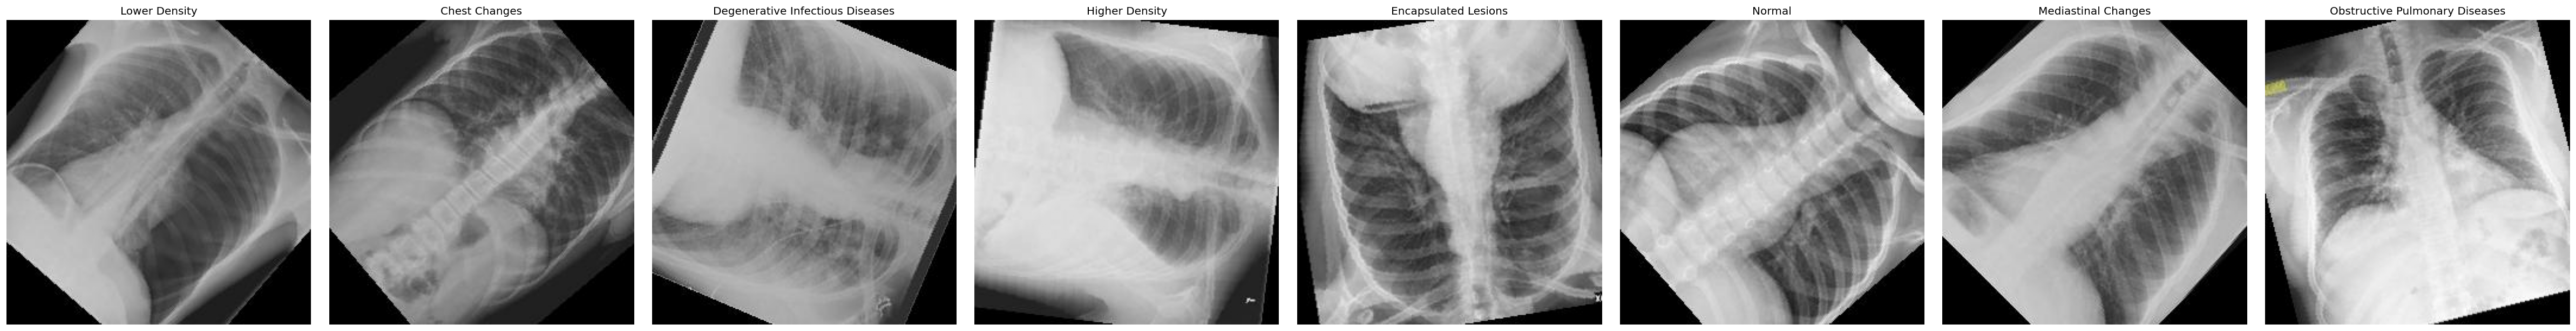

In [72]:
# show index wise one sample from each class
utils.show_images(df)

In [77]:
# initally 1000 samples from each class have been taken
samples_per_class = 1000

# Group by label and sample
df_sampled = (
    df.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(n=samples_per_class, random_state=42))
      .reset_index(drop=True)
)

# Verify 1000 per class
print(df_sampled['label'].value_counts())
print(f"Total samples: {len(df_sampled)}")

label
Chest Changes                       1000
Degenerative Infectious Diseases    1000
Encapsulated Lesions                1000
Higher Density                      1000
Lower Density                       1000
Mediastinal Changes                 1000
Normal                              1000
Obstructive Pulmonary Diseases      1000
Name: count, dtype: int64
Total samples: 8000


/tmp/ipython-input-2386910067.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=samples_per_class, random_state=42))


In [78]:
from sklearn.preprocessing import LabelEncoder

# create instance of label encoder
le = LabelEncoder()

# Fit the encoder and transform labels
df_sampled['label'] = le.fit_transform(df_sampled['label'])

# Check mapping of class label
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", *label_mapping.items(), sep="\n")

# Show 5 random rows from df_sampled
df_sampled.sample(10, random_state=None)

Label Mapping:
('Chest Changes', np.int64(0))
('Degenerative Infectious Diseases', np.int64(1))
('Encapsulated Lesions', np.int64(2))
('Higher Density', np.int64(3))
('Lower Density', np.int64(4))
('Mediastinal Changes', np.int64(5))
('Normal', np.int64(6))
('Obstructive Pulmonary Diseases', np.int64(7))


,path,label
721,/content/dataset/Main dataset/Chest Changes/im...,0
2309,/content/dataset/Main dataset/Encapsulated Les...,2
1913,/content/dataset/Main dataset/Degenerative Inf...,1
3805,/content/dataset/Main dataset/Higher Density/i...,3
1374,/content/dataset/Main dataset/Degenerative Inf...,1
3254,/content/dataset/Main dataset/Higher Density/i...,3
2150,/content/dataset/Main dataset/Encapsulated Les...,2
2314,/content/dataset/Main dataset/Encapsulated Les...,2
6272,/content/dataset/Main dataset/Normal/image_573...,6
7502,/content/dataset/Main dataset/Obstructive Pulm...,7


# 2. Data Exploration

## 2.1 Image Dimension and Color Mode Analysis

In [79]:
from PIL import Image

# get image size (width, height) from file paths
sizes = df_sampled['path'].apply(lambda p: Image.open(p).size)

# get image color mode from file paths (e.g., 'L', 'RGB')
modes = df_sampled['path'].apply(lambda p: Image.open(p).mode)

print("\nImage size distribution:")
print(sizes.value_counts())

print("\nImage mode distribution:")
print(modes.value_counts())


Image size distribution:
path
(256, 256)    8000
Name: count, dtype: int64

Image mode distribution:
path
L      4636
RGB    3364
Name: count, dtype: int64


## 2.2 Data Imbalanace

Data Set distribution in percentage:
Degenerative Infectious Diseases --> 12.50%
Encapsulated Lesions --> 12.50%
Obstructive Pulmonary Diseases --> 12.50%
Higher Density --> 12.50%
Mediastinal Changes --> 12.50%
Normal --> 12.50%
Lower Density --> 12.50%
Chest Changes --> 12.50%
The Data set properly balanced


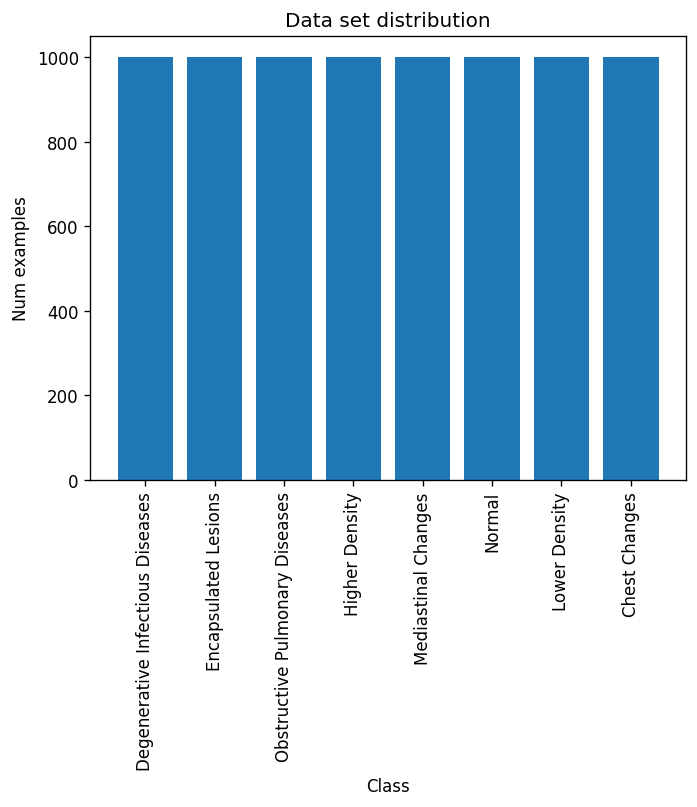

In [80]:
import explore

# class labels of all samples
labels = df_sampled['label']

# check data imbalance and present in proportion
explore.check_df_imbalance(labels, cfg.class_names)

# plot data distribution
explore.plot_label_distribution(labels, cfg.class_names)

## 2.2 Duplicates

In [81]:
explore.compute_duplicate(df)

Total rows: 80000
Duplicate rows (excluding first occurrences): 0
Duplicate groups : 0

Class-wise duplicate rows:
No  duplicates found.


## 2.3 Pixel Intensity Statistics


Overall Pixel Intensity Statistics (grayscale)
 count: 524288000
   min: 0.0
   max: 255.0
  mean: 124.33042677116394
   std: 66.17088816448441
   class     count  min    max        mean        std
0      0  13107200  0.0  255.0  122.331770  64.678646
1      1  13107200  0.0  255.0  120.796310  67.157810
2      2  13107200  0.0  255.0  123.414558  66.536085
3      3  13107200  0.0  255.0  129.385269  70.412770
4      4  13107200  0.0  255.0  126.638041  64.707048
5      5  13107200  0.0  255.0  116.951959  62.917427
6      6  13107200  0.0  255.0  124.879219  66.004653
7      7  13107200  0.0  255.0  130.064395  68.226331


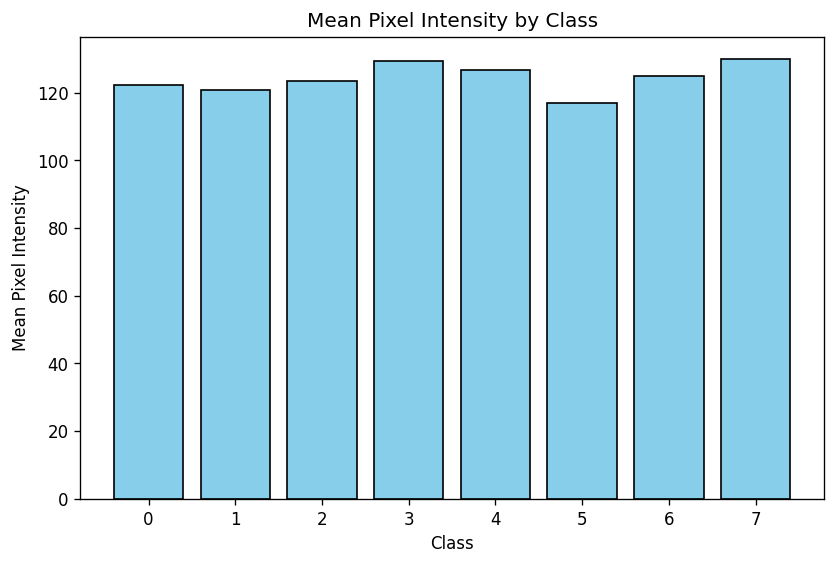

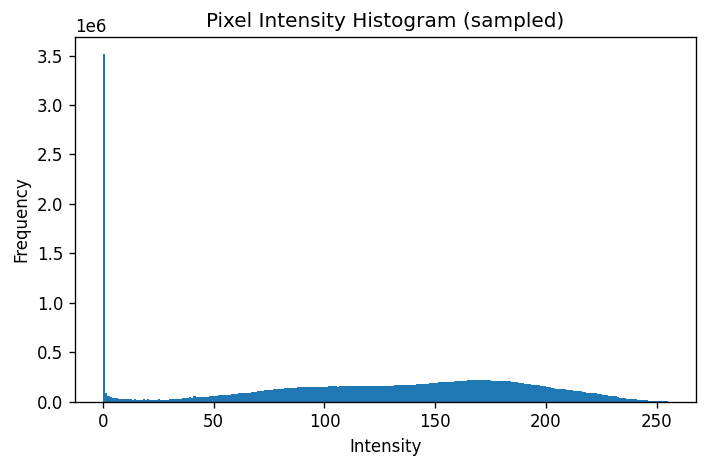

In [88]:
# print pixel intensity statistics
explore.pixel_stats_overall(df_sampled, path_col="path", as_gray=True)

# class wise pixel statistics
explore.pixel_stats_by_class(
    df_sampled, path_col="path",
    label_col="label", as_gray=True,
    sample_per_class=200
    )

# Plot histogram of mean pixel intensity based on selected samples
explore.plot_pixel_histogram(
    df_sampled, path_col="path",
    as_gray=True, bins=256, sample=500
    )

**`Findings`** – Pixel Intensity Analysis (Grayscale)
- Pixel values span the full range 0–255, confirming no clipping during preprocessing.

- The overall mean intensity (~124) suggests a moderately bright dataset.

- A large spike near intensity 0 indicates many black/dark background pixels, typical for X-ray images.

- Per-class means (116–130) and standard deviations (~62–71) are relatively close, implying no severe brightness imbalance across classes.

- The histogram shows a broad spread of intensities, meaning images retain good contrast and are not uniformly dark or bright.


In [ ]:
import os
from PIL import Image

for p in df_sampled['path'].head(5):
    print(p, os.path.exists(p))  # Check if file exists

    try:
        with Image.open(p) as im:
            print("Opened:", im.size, im.mode)
    except Exception as e:
        print("Error:", e)

/content/dataset/Main dataset/Chest Changes/image_74513.jpg True
Opened: (256, 256) RGB
/content/dataset/Main dataset/Chest Changes/image_28509.jpg True
Opened: (256, 256) L
/content/dataset/Main dataset/Chest Changes/image_41783.jpg True
Opened: (256, 256) RGB
/content/dataset/Main dataset/Chest Changes/image_48294.jpg True
Opened: (256, 256) RGB
/content/dataset/Main dataset/Chest Changes/image_14354.jpg True
Opened: (256, 256) L
